In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)
from yellowbrick.model_selection import (
    ValidationCurve,
)

url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)


X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
dt = DecisionTreeClassifier(
    random_state=42, max_depth=3
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [16]:
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X.columns,
    class_names=["died", "survived"],
)
exp = explainer.explain_instance(
    X_train.iloc[-1].values, dt.predict_proba
)

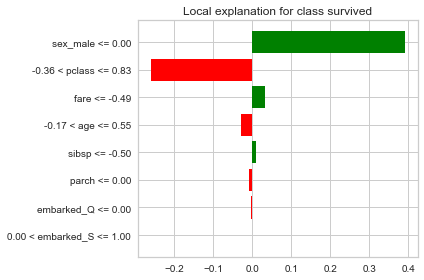

In [17]:
fig = exp.as_pyplot_figure()
fig.tight_layout()
#fig.savefig("images/mlpr_1301.png")

In [18]:
data = X_train.iloc[-2].values.copy()
dt.predict_proba(
    [data]
)  # predicting that a woman lives
data[5] = 1  # change to male
dt.predict_proba([data])

array([[0.87954545, 0.12045455]])

In [19]:
rf5 = ensemble.RandomForestClassifier(
    **{
        "max_features": "auto",
        "min_samples_leaf": 0.1,
        "n_estimators": 200,
        "random_state": 42,
    }
)
rf5.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [20]:
from treeinterpreter import (
    treeinterpreter as ti,
)
instances = X.iloc[:2]
prediction, bias, contribs = ti.predict(
    rf5, instances
)
i = 0
print("Instance", i)
print("Prediction", prediction[i])
print("Bias (trainset mean)", bias[i])
print("Feature contributions:")
for c, feature in zip(
    contribs[i], instances.columns
):
    print("  {} {}".format(feature, c))

Instance 0
Prediction [0.82046191 0.17953809]
Bias (trainset mean) [0.63887555 0.36112445]
Feature contributions:
  pclass [ 0.02865085 -0.02865085]
  age [ 0.01115629 -0.01115629]
  sibsp [ 0.00528926 -0.00528926]
  parch [ 0.00656872 -0.00656872]
  fare [ 0.04126856 -0.04126856]
  sex_male [ 0.07660626 -0.07660626]
  embarked_Q [0. 0.]
  embarked_S [ 0.01204643 -0.01204643]


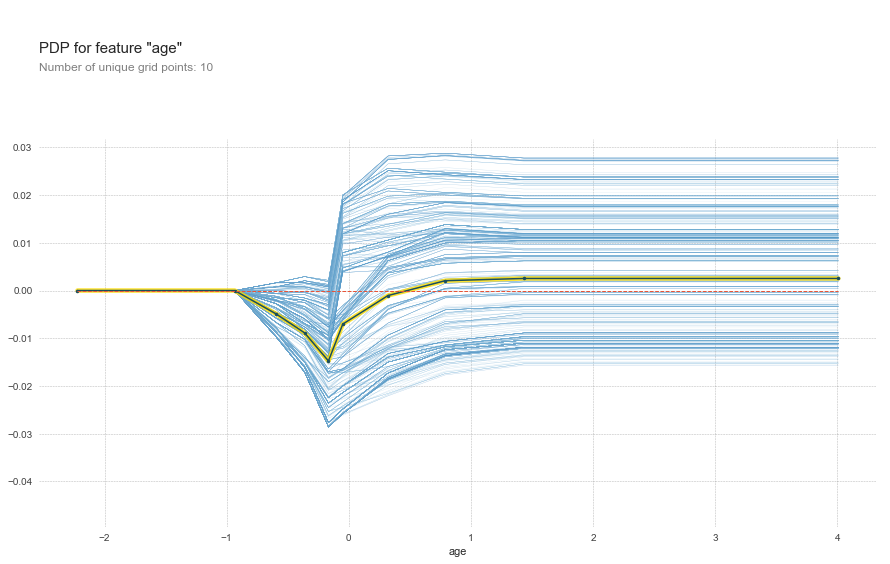

In [21]:
from pdpbox import pdp
feat_name = "age"
p = pdp.pdp_isolate(
    rf5, X, X.columns, feat_name
)
fig, _ = pdp.pdp_plot(
    p, feat_name, plot_lines=True
)
#fig.savefig("images/mlpr_1302.png", dpi=300)

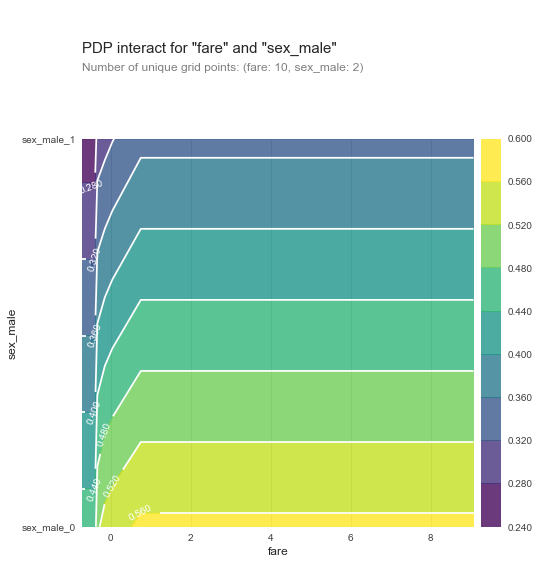

In [22]:
features = ["fare", "sex_male"]
p = pdp.pdp_interact(
    rf5, X, X.columns, features
)
fig, _ = pdp.pdp_interact_plot(p, features)
#fig.savefig("images/mlpr_1303.png", dpi=300)

In [23]:
from sklearn import svm
sv = svm.SVC()
sv.fit(X_train, y_train)
sur_dt = tree.DecisionTreeClassifier()
sur_dt.fit(X_test, sv.predict(X_test))
for col, val in sorted(
    zip(
        X_test.columns,
        sur_dt.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:7]:
    print(f"{col:10}{val:10.3f}")

sex_male       0.723
pclass         0.077
sibsp          0.061
age            0.061
embarked_S     0.050
fare           0.022
parch          0.005


In [24]:
rf5.predict_proba(X_test.iloc[[20]])

array([[0.60129761, 0.39870239]])

In [29]:
import shap
shap.initjs()
s = shap.TreeExplainer(rf5)
shap_vals = s.shap_values(X_test)
target_idx = 1
shap.force_plot(
    s.expected_value[target_idx],
    shap_vals[target_idx][20, :],
    feature_names=X_test.columns,
)

In [30]:
shap.force_plot(
    s.expected_value[1],
    shap_vals[1],
    feature_names=X_test.columns,
)

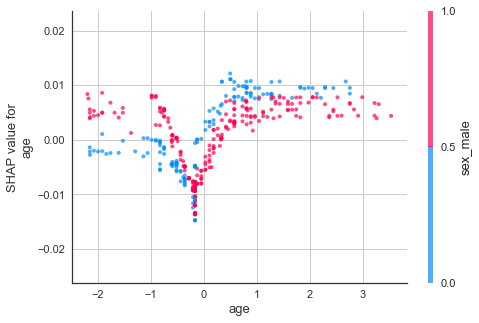

In [31]:
fig, ax = plt.subplots(figsize=(6, 4))
res = shap.dependence_plot(
    "age",
    shap_vals[target_idx],
    X_test,
    feature_names=X_test.columns,
    alpha=0.7,
)
# fig.savefig(
#     "images/mlpr_1306.png",
#     bbox_inches="tight",
#     dpi=300,
# )

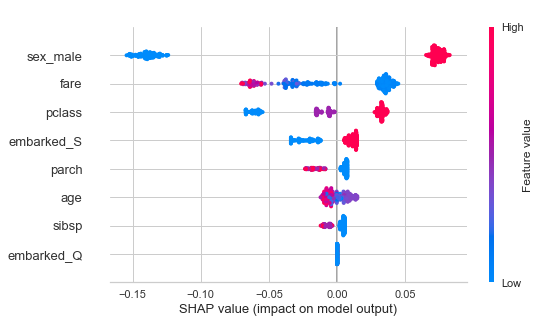

In [32]:
fig, ax = plt.subplots(figsize=(6, 4))
shap.summary_plot(shap_vals[0], X_test)
#fig.savefig("images/mlpr_1307.png", dpi=300)